# Rebel/Geru Warehouse Financing
### Scenario Simulator
Assuming a warehouse facility with terms detailed as variables below.

In [15]:
# Import of necessary Python Libraries
from datetime import timedelta
from dateutil import parser
from dateutil.relativedelta import relativedelta 
from IPython.display import display, HTML

import pandas as pd
import numpy as np
import numpy_financial as npf

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

In [16]:
# Global Variables
# ----------------
# Indicative Terms of Facility
COUNTERPARTY = 'GS Bank'
CURRENCY = 'BRL'
USDBRL = 5.40
SIZE_USD = 180e6
SIZE_BRL = SIZE_USD * USDBRL
COMMITED_USD = 60e6
COMMITED_BRL = COMMITED_USD * USDBRL
UNCOMMITED_USD = SIZE_USD - COMMITED_USD
UNCOMMITED_BRL = SIZE_BRL - COMMITED_BRL
START_DATE = parser.parse("01-01-2021")
TERM = 48  # In Months
END_DATE = START_DATE + relativedelta(months=TERM)
REVOLV_PERIOD = 30  # In Months
END_REVOLV_DATE = START_DATE + relativedelta(months=REVOLV_PERIOD)
AMORT_PERIOD = TERM - REVOLV_PERIOD

# Fees
SERVICING_FEE = 0.03
ORIGINATION_FEE = 0.05
UPFRONT_FEE = 0.01
NON_USE_FEE = 0.01
# Min utilization fee below is in the format (month_beginning, fee)
MIN_FEE_SCHEDULE = [(0, 0.25), (3, 0.40), (6, 0.6), (12, 0.75)]
EXIT_FEE = 0.02

# Spread and rates
# ADVANCE_RATE = 0.70  # of the unpaid balance of each loan
ADVANCE_RATE = [(0, 0.65), (9, 0.70), (15, 0.75)]
N_DAYS_AR_ZERO = 30  # After 30 days late, loan AR = 0
COUPON_CDI_SPREAD = 400
AMORT_PERIOD_SPREAD = 50  # Additional spread during amort period
RAPID_AMORT_SPREAD = 100
CDI_FLOOR = 0.015
CDI = 0.04  # Assumed CDI level for whole period

# Indicative Equity Terms
LEAD_EQUITY = 10e6
MIN_ROUND_SIZE = 25e6
PRE_MONEY_VAL = 200e6
LEAD_WARRANTS = 0.01

# Simulation Variables
# Origination Volumes per month (at start and end dates - linear growth assumed)
# Note that end date is the FINAL date of the facility, not the end of revolving period
OV_START = 10e6
OV_END = 300e6
# Default table for life of loan. Assumed to increase linearly from start to end for the life of loan
DEFAULT_START = 0.05
DEFAULT_END = 0.20
# Average Loan Details (all values in BRL)
LOAN_TERM = 24
LOAN_IR = 0.04  # Monthly Interest Rate
# Include CAC and OPEX
CAC = 0.08  # as percentage of origination
OPEX = 5e6  #expected opex per month in BRL


#### !!!!!! IMPORTANT !!!!!!!!!!!
Assumption here is that coverage ratio is equal to the percentage of the book that is delinquent.
In specific, if 10% of payments expected are not received, the book notional is also written off by 10%.

### Loan Book Balance Sheet


| *Assets*               | *Liabilities* |
|:---------------------  |:-------------------------------------------------------|
| Cash                   | Lender Balance (shoulbe be AR x Net Loan Principal) |
| Loan Principal Outs.   | Borrower Balance |
| (-) Write-Offs         |   |
| Net Loan Principal     | *Equity (Assets - Liabilities)*|




In [17]:
# Create Monthly cash flows
# Start by creating an empty dataframe only with monthly dates from START_DATE to END_DATE
index = pd.date_range(start=START_DATE, end=END_DATE, freq='M', closed='right', normalize=True)
df = pd.DataFrame(index=index)

# Include Origination Amounts in dataframe and interpolate in between
df['loan_origination'] = np.nan
df.iloc[0, df.columns.get_loc('loan_origination')] = OV_START
df.iloc[-1, df.columns.get_loc('loan_origination')] = OV_END
df['loan_origination'] = df['loan_origination'].interpolate()

# Include empty columns + other columns
df['dates'] = df.index
zero_list = ['payments_expected', 'cash_balance', 'margin_call', 
            'cash_balance', 'interest_paid', 'upfrontfee_paid', 'nonuse_fee', 'loan_book',
            'lender_balance', 'interest_expected', 'amort_expected', 'amort_received', 
            'interest_received', 'payments_received', 'borrower_balance',
            'origination_cum', 'amort_cum', 'servicing_fee']
for element in zero_list:
    df[element] = 0
df['messages'] = ''
# Include counter column
df['counter'] = range(len(df))

# Reset index to use counter
df = df.set_index('counter')

In [18]:
# Loop through the dates to calculate cash flows
for index, row in df.iterrows():
    # Only originate new loans if date is still in revolving period
    if (index > REVOLV_PERIOD - 1) or ():
        df.loc[index, 'loan_origination'] = 0
    
    # if LOAN_TERM is longer than months left until the end of facility, adjust so it's equal to facility term
    # in other words, new originations don't go past the end of facility life
    months_left = TERM - index
    if months_left < LOAN_TERM:
        LOAN_TERM = months_left - 1

    # Check if facility still has balance, if not, cannot originate anymore
    used = df['lender_balance'].iloc[index - 1]  # previous balance
    origination = df.loc[index, 'loan_origination']  # current origination
    non_used = SIZE_BRL - used
    full = False
    if (used + origination) > SIZE_BRL:
        full = True
        # Adjust origination for this period
        df.loc[index, 'loan_origination'] = non_used
        df.loc[index, 'messages'] += ' [FACILITY FULL] '

    # PMT, Amort and Int due Calculations
    months = np.arange(1, LOAN_TERM + 1)
    pmt = npf.pmt(LOAN_IR, LOAN_TERM, df.loc[index, 'loan_origination']) * (-1)
    int = npf.ipmt(LOAN_IR, months,LOAN_TERM, df.loc[index, 'loan_origination']) * (-1)
    amort = npf.ppmt(LOAN_IR, months, LOAN_TERM, df.loc[index, 'loan_origination']) * (-1)

    # fill the next [LOAN_TERM] months with pmts, int and amort
    for n in range (1, LOAN_TERM + 1): 
        # interpolate from default table (linearly)
        default_period = DEFAULT_START + ((DEFAULT_END - DEFAULT_START) / (LOAN_TERM - 1)) * (n - 1)
        df.loc[index+n-1, 'payments_expected'] = df.loc[index+n-1, 'payments_expected'] + pmt
        df.loc[index+n-1, 'interest_expected'] = df.loc[index+n-1, 'interest_expected'] + int[n-1]
        df.loc[index+n-1, 'amort_expected'] = df.loc[index+n-1, 'amort_expected'] + amort[n-1]
        # Payments expected are adjusted according to the linear default table
        df.loc[index+n-1, 'payments_received'] = df.loc[index+n-1, 'payments_received'] + (pmt * (1 - default_period))
        df.loc[index+n-1, 'interest_received'] = df.loc[index+n-1, 'interest_received'] + (int[n-1] * (1 - default_period))
        df.loc[index+n-1, 'amort_received'] = df.loc[index+n-1, 'amort_received'] + (amort[n-1] * (1 - default_period))
    
    # Current book mark to market and cash flows from borrower
    if index == 0:
        # At closing, the upfront fee on commited amount is charged and added to the lender balance
        # ------------ CONFIRM this is the correct dynamic to reflect t/s ---------------------
        df.loc[index, 'messages'] += ' [Closing Date] '
        upfront_amount = UPFRONT_FEE * COMMITED_BRL
        df.loc[index, 'cash_balance'] -= upfront_amount
        df.loc[index, 'upfrontfee_paid'] += upfront_amount
        
    # Copy some values from previous row
    else:
        elements = ['loan_book', 'cash_balance', 'lender_balance', 'borrower_balance', 
                    'interest_paid', 'origination_cum', 'amort_cum']
        for element in elements:
            df.loc[index, element] = df[element].iloc[index - 1]

    # Increment origination, amortization to keep track of totals
    df.loc[index, 'amort_cum'] += df.loc[index, 'amort_received']
    df.loc[index, 'origination_cum'] += df.loc[index, 'loan_origination']

    # 1. Adjust the bad borrower provisions (write-offs) and loan book (see important note above)
    # The def rate below is how much (on average) the payments are being covered, here we use
    # the same rate to discount the loan book
    default_rate = 1 - (df.loc[index, 'payments_received'] / df.loc[index, 'payments_expected'])
    df.loc[index, 'default_rate'] = default_rate
    
    # Mark the book down -> book = (all origin - all amortizations) x (1 - d)
    df.loc[index, 'loan_book'] = max(0, (df.loc[index, 'origination_cum'] * (1 - default_rate)) - df.loc[index, 'amort_cum'])

    # 2. New Originations => (+)Loans , (-)Cash
    df.loc[index, 'cash_balance'] -= df.loc[index, 'loan_origination']

    # 3. Payments received (reduce loan balance + increase cash)
    # HERE REDUCE ONLY BY AMORTIZATION since facility looks at unpaid principal value
    df.loc[index, 'cash_balance'] += df.loc[index, 'payments_received']
    
    # 4. Debit cash of interest + fees that need to be paid
    # Cost of Facility - interest owed to lender 
    # Adjust spread up during amortization period
    spread = COUPON_CDI_SPREAD if (index < REVOLV_PERIOD) else (COUPON_CDI_SPREAD + AMORT_PERIOD_SPREAD)
    # Calculate cost
    interest_charge = (( 1 + (spread/10000 + CDI)) ** (1/12)) - 1
    df.loc[index, 'interest_charge'] = interest_charge
    df.loc[index, 'cash_balance'] -= df.loc[index, 'lender_balance'] * interest_charge 
    df.loc[index, 'interest_paid'] += df.loc[index, 'lender_balance'] * interest_charge

    # 5. Include other fees like min utilization fee + calculate servicing + origination fee to borrower
    # a. Upfront fee 
    # if loan book > commited amount, new upfront fees will be charged 
    # Increase Lender Balance by the upfront origination fee
    if used > COMMITED_BRL:
        df.loc[index, 'messages'] += '[ABOVE COMMITED AMOUNT] '
        upfront_amount = UPFRONT_FEE * df.loc[index, 'loan_origination']
        df.loc[index, 'lender_balance'] += upfront_amount
        df.loc[index, 'upfrontfee_paid'] += upfront_amount
    # b. Min Utilization fee / Non-Use fee
    # NEED TO CHECK / CONFIRM THAT THIS IS NOT CHARGED DURING THE AMORTIZATION PERIOD
    # BUT FOR HERE, ASSUMING THAT IT IS NOT
    min_util = False
    if index < REVOLV_PERIOD:
        for item in MIN_FEE_SCHEDULE:
            if index >= item[0]:
                min_current_usage = item[1]
            min_usage_level = min_current_usage * COMMITED_BRL
            # If facility below the minimum utilization level, pay fee
            if df.loc[index, 'lender_balance'] < min_usage_level:
                min_util = True
                df.loc[index, 'cash_balance'] -= min_usage_level * NON_USE_FEE
                df.loc[index, 'nonuse_fee'] += min_usage_level * NON_USE_FEE 
        if min_util:
            df.loc[index, 'messages'] += '[BELOW MIN UTIL LEVEL] '
    else:
        df.loc[index, 'messages'] += '[AMMORTIZATION PERIOD] '

    # 6. Adjust cash balances, check for margin calls
    # Two scenarios here: a) Cash is negative, make calls; b) Cash is positive, pay down balances
    # Check Advance Rate for current period
    for item in ADVANCE_RATE:
        if index >= item[0]:
            ar_period = item[1]
    df.loc[index, 'current_ar'] = ar_period
    
    if df.loc[index, 'cash_balance'] < 0:
        df.loc[index, 'messages'] += '[NEGATIVE CASH] '
        
        # First tap the credit line for this cash, then make adjustments if AR not met by base
        df.loc[index, 'lender_balance'] -= df.loc[index, 'cash_balance']
        df.loc[index, 'cash_balance'] = 0 

        # OK, now that the credit line was taped to cover cash, let's check if there's need 
        # for borrower to bring back the ratios
        
        ar = df.loc[index, 'loan_book'] * ar_period
        # is there balance on the advance rate? If so, no adjustment needed. Else, bring to balance.
        excess_ar = ar - df.loc[index, 'lender_balance']
        if excess_ar < 0:
            df.loc[index, 'lender_balance'] += excess_ar
            df.loc[index, 'borrower_balance'] -= excess_ar
            df.loc[index, 'margin_call'] += excess_ar
            df.loc[index, 'messages'] += '[MARGIN CALL] '

    else:
        df.loc[index, 'messages'] += '[POSITIVE CASH] '
        # Make distributions if there's balance to pay lender or borrower ONLY IF during amortization period
        if (df.loc[index, 'lender_balance'] > 0) and (index >= REVOLV_PERIOD): 
            # Check if cash is larger than balance
            if df.loc[index, 'lender_balance'] > df.loc[index, 'cash_balance']: 
                df.loc[index, 'lender_balance'] -= df.loc[index, 'cash_balance']
                df.loc[index, 'cash_balance'] = 0 
            else:
                df.loc[index, 'cash_balance'] -= df.loc[index, 'lender_balance']
                df.loc[index, 'lender_balance'] = 0

        elif (df.loc[index, 'borrower_balance'] > 0) and (index >= REVOLV_PERIOD):
            # Check if cash is larger than balance
            if df.loc[index, 'borrower_balance'] > df.loc[index, 'cash_balance']: 
                df.loc[index, 'borrower_balance'] -= df.loc[index, 'cash_balance']
                df.loc[index, 'cash_balance'] = 0 
            else:
                df.loc[index, 'cash_balance'] -= df.loc[index, 'borrower_balance']
                df.loc[index, 'borrower_balance'] = 0

        # Make CDI Payment to cash --- Assumption that cash earns CDI flat here
        if df.loc[index, 'cash_balance'] > 0:
            df.loc[index, 'messages'] += '[CASH EARNED CDI] '
            df.loc[index, 'cash_balance'] += df.loc[index, 'cash_balance'] * (CDI)
    
    # Include servicing fee
    df.loc[index, 'servicing_fee'] = df.loc[index, 'payments_received'] * SERVICING_FEE
        

In [19]:
heading = '<h1>Warehouse Facility Overview of inputs</h1>'
table1 = '<table>'

display(HTML(heading))
list_variables = dir()
inputs = []
for element in list_variables:
    if element == element.upper() and '_' not in element[0]:
        inputs.append(element)

table_html = '''
<table>
<thead>
  <tr>
    <td style='text-align: left;'>
      Input
    </td>
    <td style='text-align: right;'>
      Value
    </td>
    <td>
    Type
    </td>
  </tr>
</thead>
<tbody>
'''

for input in inputs:
    tmp = eval(input)
    # format
    try:
        tmp = float(tmp)
        if tmp > 1:
            tmp = "{0:,.2f}".format(tmp)
        else:
            tmp = "{0:,.4f}".format(tmp)
    except Exception:
        pass
    table_html += "<tr><td style='text-align: left;'>" + input + "</td><td style='text-align: right;'>" + str(tmp) + "</td><td>" + type(eval(input)).__name__ + "</td></tr>"
  
table_html += '</tbody></table>'

display(HTML(table_html))

Input,Value,Type
ADVANCE_RATE,"[(0, 0.65), (9, 0.7), (15, 0.75)]",list
AMORT_PERIOD,18.00,int
AMORT_PERIOD_SPREAD,50.00,int
CAC,0.0800,float
CDI,0.0400,float
CDI_FLOOR,0.0150,float
COMMITED_BRL,"324,000,000.00",float
COMMITED_USD,"60,000,000.00",float
COUNTERPARTY,GS Bank,str
COUPON_CDI_SPREAD,400.00,int


In [20]:
# Borrower Cash Flows and IRR calculations
pd.options.display.float_format = '{:,.0f}'.format
cols = ['dates', 'loan_origination', 'borrower_balance', 'cash_balance', 'margin_call', 'loan_book', 'interest_paid', 'upfrontfee_paid', 'nonuse_fee', 'current_ar', 'servicing_fee']
df_b = df[cols]
df_b['origination_fee'] = ORIGINATION_FEE * df_b['loan_origination']
df_b['borrower_balance_change'] = df_b['borrower_balance'].diff().fillna(0) * (-1)

df_b['CAC'] = -CAC * df_b['loan_origination']
df_b['OPEX'] = -OPEX

df_b['borrower_cash_flow'] = df_b['origination_fee'] + df_b['servicing_fee'] + df_b['borrower_balance_change'] + df_b['CAC'] + df_b['OPEX']

# Include cash distribution at the end if lender is fully paid
if df.iloc[-1]['lender_balance'] == 0:
    df_b.iloc[-1, df_b.columns.get_loc('borrower_cash_flow')] += df.iloc[-1]['cash_balance']

df_b['borrower_cf_cum'] = df_b['borrower_cash_flow'].cumsum()

stats_html = '</h1>Borrower Cash flows</h1>'
negative_cf = df_b[df_b['borrower_cash_flow'] < 0]['borrower_cash_flow'].sum()
positive_cf = df_b[df_b['borrower_cash_flow'] > 0]['borrower_cash_flow'].sum()
stats_html += '<p>Sum of negative cash flows: ' + str('{:,.0f}'.format(negative_cf)) + '</p>'
stats_html += '<p>Sum of positive cash flows: ' + str('{:,.0f}'.format(positive_cf)) + '</p>'

display(HTML(stats_html))

df_b[['dates', 'origination_fee', 'servicing_fee', 'borrower_balance_change', 'CAC', 'OPEX', 'borrower_cash_flow', 'borrower_cf_cum']]

,dates,origination_fee,servicing_fee,borrower_balance_change,CAC,OPEX,borrower_cash_flow,borrower_cf_cum
counter,,,,,,,,
0,2021-01-31,"500,000","18,692",-0,"-800,000","-5,000,000","-5,281,308","-5,281,308"
1,2021-02-28,"808,511","48,790","-8,298,566","-1,293,617","-5,000,000","-13,734,883","-19,016,191"
2,2021-03-31,"1,117,021","90,213","-9,774,442","-1,787,234","-5,000,000","-15,354,442","-34,370,632"
3,2021-04-30,"1,425,532","142,883","-12,490,811","-2,280,851","-5,000,000","-18,203,247","-52,573,879"
4,2021-05-31,"1,734,043","206,721","-13,537,019","-2,774,468","-5,000,000","-19,370,723","-71,944,602"
5,2021-06-30,"2,042,553","281,648","-14,376,498","-3,268,085","-5,000,000","-20,320,382","-92,264,984"
6,2021-07-31,"2,351,064","367,584","-15,500,773","-3,761,702","-5,000,000","-21,543,828","-113,808,812"
7,2021-08-31,"2,659,574","464,449","-15,943,462","-4,255,319","-5,000,000","-22,074,757","-135,883,569"
8,2021-09-30,"2,968,085","572,166","-14,900,276","-4,748,936","-5,000,000","-21,108,961","-156,992,530"


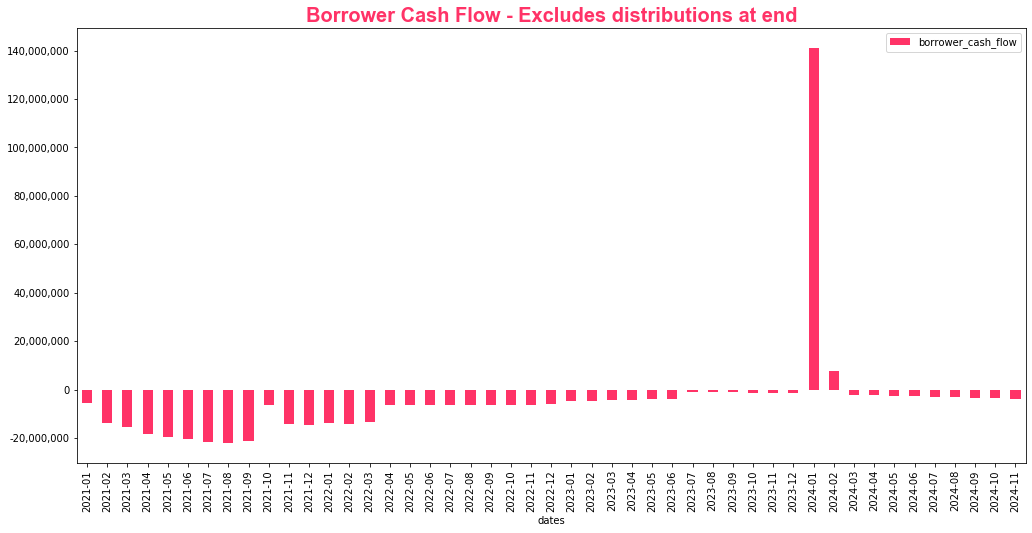

In [21]:
# Borrower Cash Flow Chart
try:
    df_b['dates'] = df_b['dates'].dt.strftime('%Y-%m')
    df_b.drop(df_b.tail(1).index,inplace=True)
except Exception:
    pass
ax = df_b.plot(kind='bar',x='dates',y='borrower_cash_flow', figsize=(17,8), color="#ff3367")
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
font = {'family': 'arial',
        'color':  "#ff3367",
        'weight': 'bold',
        'size': 20,
        }
plt.title('Borrower Cash Flow - Excludes distributions at end', fontdict=font)
plt.show()

In [22]:
# Show df
cols = ['dates', 'loan_origination', 'payments_received', 'default_rate','lender_balance', 'borrower_balance', 'cash_balance', 'margin_call', 'loan_book', 'interest_paid', 'upfrontfee_paid', 'nonuse_fee', 'current_ar', 'servicing_fee']
pd.options.display.float_format = '{:,.2f}'.format
df_f = df[cols]
df_f['serv_fee_cum'] = df_f['servicing_fee'].cumsum()
df_f['max_serv_fee'] = 0.02 * df_f['loan_book']
df_f['serv_fee_difference'] = df_f['max_serv_fee'] - df_f['serv_fee_cum']
df_f

,dates,loan_origination,payments_received,default_rate,lender_balance,borrower_balance,cash_balance,margin_call,loan_book,interest_paid,upfrontfee_paid,nonuse_fee,current_ar,servicing_fee,serv_fee_cum,max_serv_fee,serv_fee_difference
counter,,,,,,,,,,,,,,,,,
0,2021-01-31,"10,000,000.00","623,074.90",0.05,"6,017,001.32","9,839,923.79",0.00,"-9,839,923.79","9,256,925.10",0.00,"3,240,000.00","3,240,000.00",0.65,"18,692.25","18,692.25","185,138.50","166,446.26"
1,2021-02-28,"16,170,212.77","1,626,322.86",0.05,"15,541,038.58","18,138,490.00",0.00,"-8,298,566.21","23,909,290.12","38,713.57",0.00,"3,240,000.00",0.65,"48,789.69","67,481.93","478,185.80","410,703.87"
2,2021-03-31,"22,340,425.53","3,007,104.65",0.05,"28,439,908.92","27,912,932.05",0.00,"-9,774,442.05","43,753,706.04","138,705.08",0.00,"3,240,000.00",0.65,"90,213.14","157,695.07","875,074.12","717,379.05"
3,2021-04-30,"28,510,638.30","4,762,781.00",0.06,"44,577,938.44","40,403,743.06",0.00,"-12,490,811.01","68,581,443.75","321,688.31",0.00,"4,698,000.00",0.65,"142,883.43","300,578.50","1,371,628.88","1,071,050.37"
4,2021-05-31,"34,680,851.06","6,890,712.68",0.06,"63,815,874.13","53,940,761.56",0.00,"-13,537,018.50","98,178,267.88","608,504.11",0.00,"4,698,000.00",0.65,"206,721.38","507,299.88","1,963,565.36","1,456,265.48"
5,2021-06-30,"40,851,063.83","9,388,260.43",0.06,"86,010,772.81","68,317,259.53",0.00,"-14,376,497.97","132,324,265.86","1,019,097.36",0.00,"4,698,000.00",0.65,"281,647.81","788,947.70","2,646,485.32","1,857,537.62"
6,2021-07-31,"47,021,276.60","12,252,785.00",0.06,"111,015,886.89","83,818,032.95",0.00,"-15,500,773.41","170,793,672.14","1,572,493.26",0.00,"5,184,000.00",0.65,"367,583.55","1,156,531.25","3,415,873.44","2,259,342.20"
7,2021-08-31,"53,191,489.36","15,481,647.16",0.07,"138,680,546.84","99,761,494.76",0.00,"-15,943,461.81","213,354,687.45","2,286,772.82",0.00,"5,184,000.00",0.65,"464,449.41","1,620,980.66","4,267,093.75","2,646,113.09"
8,2021-09-30,"59,361,702.13","19,072,207.65",0.07,"168,850,040.39","114,661,770.51",0.00,"-14,900,275.75","259,769,292.90","3,179,047.64",0.00,"3,888,000.00",0.65,"572,166.23","2,193,146.89","5,195,385.86","3,002,238.97"


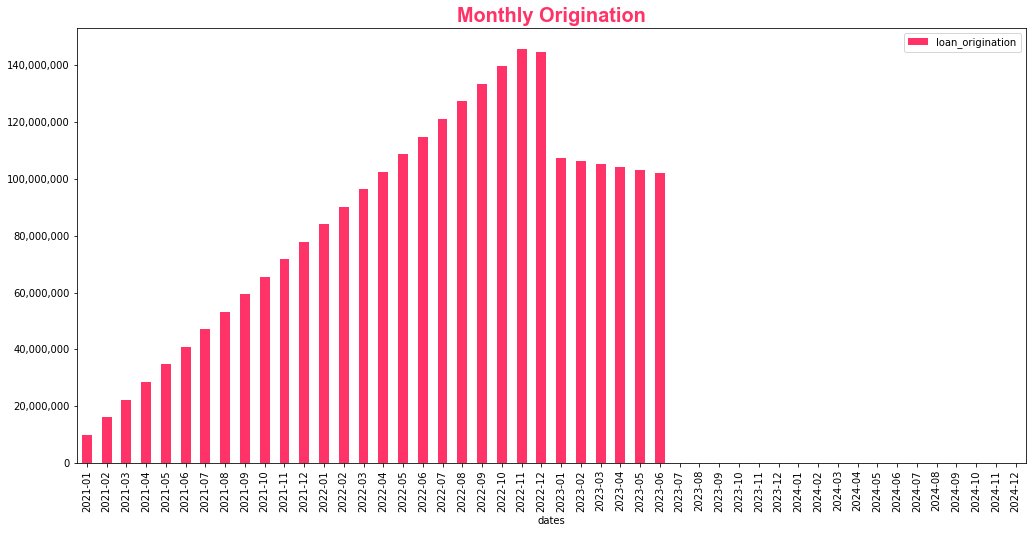

In [23]:
# Create monthly origination chart
try:
    df['dates'] = df['dates'].dt.strftime('%Y-%m')
except Exception:
    pass
ax = df.plot(kind='bar',x='dates',y='loan_origination', figsize=(17,8), color="#ff3367")
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
font = {'family': 'arial',
        'color':  "#ff3367",
        'weight': 'bold',
        'size': 20,
        }
plt.title('Monthly Origination', fontdict=font)
plt.show()

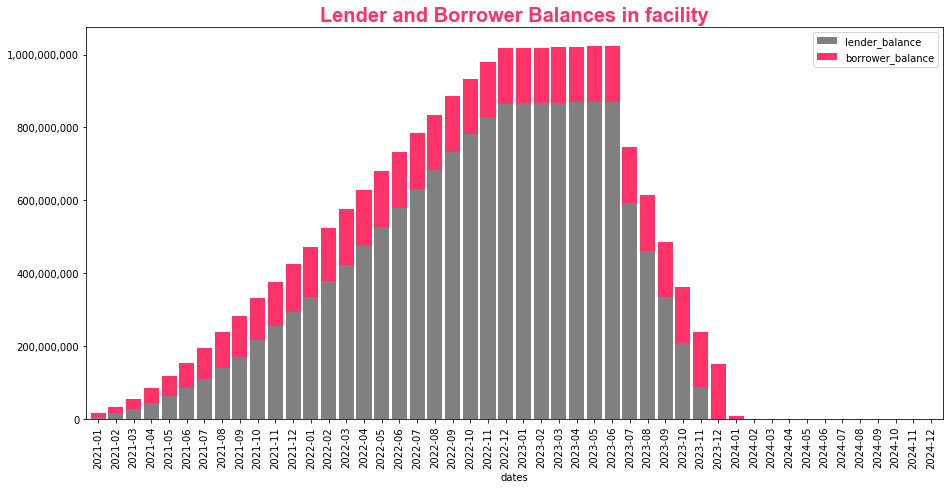

In [28]:
# Create Facility Size and Borrower Size chart
ax = df.plot(kind='bar',x='dates',y=['lender_balance', 'borrower_balance'], figsize=(17,8), color=["gray", "#ff3367"], stacked=True, width=0.85)
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
font = {'family': 'arial',
        'color':  "#ff3367",
        'weight': 'bold',
        'size': 20,
        }

plt.title('Lender and Borrower Balances in facility', fontdict=font)

# Adjust layout to make room for the table:
plt.subplots_adjust(left=0.2, bottom=0.2)
plt.show()

In [25]:
# Save Dataframe into csv 
csv_file = 'df.csv'
df.to_csv(csv_file)

# Save Dataframes into xls 
xls_file = 'df.xlsx'
df.to_excel(xls_file, sheet_name='Warehouse')

# Save Borrower Cash Flows into xls
xls_file = 'borrower_cf.xlsx'
df_b.to_excel(xls_file, sheet_name='Cash Flows')
